In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


In [10]:
import dlib
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
from imutils import face_utils

# Load the pre-trained model for face detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('models/landmarks.dat')

# Directory containing subdirectories of images
base_dir = 'images'

# Directory to save cropped images
cropped_dir = 'cropped_images'

if not os.path.exists(cropped_dir):
    os.makedirs(cropped_dir)

def crop_face(image_path, output_path, padding=0.2):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        
        # Calculate padding
        pad_w = int(w * padding)
        pad_h = int(h * padding)
        
        # Apply padding to the bounding box
        x1 = max(0, x - pad_w)
        y1 = max(0, y - pad_h)
        x2 = min(image.shape[1], x + w + pad_w)
        y2 = min(image.shape[0], y + h + pad_h)
        
        # Crop and save the face image with padding
        cropped_face = image[y1:y2, x1:x2]
        cv2.imwrite(output_path, cropped_face)
        return True
    return False

# Iterate over all subdirectories and images
for person_name in os.listdir(base_dir):
    person_dir = os.path.join(base_dir, person_name)
    if os.path.isdir(person_dir):
        person_cropped_dir = os.path.join(cropped_dir, person_name)
        if not os.path.exists(person_cropped_dir):
            os.makedirs(person_cropped_dir)
        
        for img_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_name)
            output_path = os.path.join(person_cropped_dir, img_name)
            if crop_face(img_path, output_path):
                print(f'Cropped and saved {img_path} to {output_path}')
            else:
                print(f'No face detected in {img_path}')

Cropped and saved images\Colin_Powell\Colin_Powell_0001.jpg to cropped_images\Colin_Powell\Colin_Powell_0001.jpg
Cropped and saved images\Colin_Powell\Colin_Powell_0002.jpg to cropped_images\Colin_Powell\Colin_Powell_0002.jpg
Cropped and saved images\Colin_Powell\Colin_Powell_0003.jpg to cropped_images\Colin_Powell\Colin_Powell_0003.jpg
Cropped and saved images\Colin_Powell\Colin_Powell_0004.jpg to cropped_images\Colin_Powell\Colin_Powell_0004.jpg
Cropped and saved images\Colin_Powell\Colin_Powell_0005.jpg to cropped_images\Colin_Powell\Colin_Powell_0005.jpg
Cropped and saved images\Colin_Powell\Colin_Powell_0006.jpg to cropped_images\Colin_Powell\Colin_Powell_0006.jpg
Cropped and saved images\Colin_Powell\Colin_Powell_0007.jpg to cropped_images\Colin_Powell\Colin_Powell_0007.jpg
Cropped and saved images\Colin_Powell\Colin_Powell_0008.jpg to cropped_images\Colin_Powell\Colin_Powell_0008.jpg
Cropped and saved images\Colin_Powell\Colin_Powell_0009.jpg to cropped_images\Colin_Powell\Colin

In [16]:
base_dir = 'cropped_images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split=0.2
)

train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

Found 912 images belonging to 5 classes.
Found 225 images belonging to 5 classes.


In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [19]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

In [21]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 681ms/step - accuracy: 0.4188 - loss: 1.4994 - val_accuracy: 0.4667 - val_loss: 1.4222
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 680ms/step - accuracy: 0.4625 - loss: 1.4266 - val_accuracy: 0.4667 - val_loss: 1.4131
Epoch 3/100
12/29 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - accuracy: 0.4621 - loss: 1.4264

KeyboardInterrupt: 

In [7]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.8737 - loss: 0.3869
Validation accuracy: 89.78%


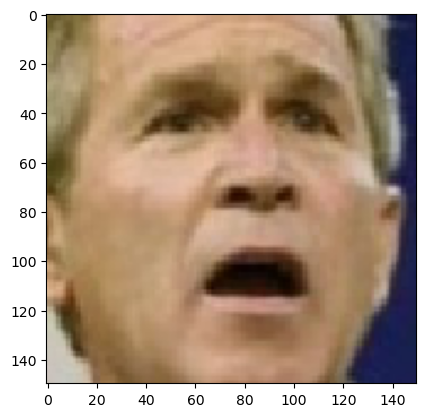

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Gambar George_W_Bush_0003.jpg diprediksi sebagai: George


In [8]:
def predict_uploaded_image(model, img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    imgplot = plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    classes = ['Colin', 'Donald', 'George', 'Gerhard', 'Tony']
    predicted_class = classes[np.argmax(predictions)]

    return predicted_class


image_directory = 'test-images'

for fn in os.listdir(image_directory):
    if fn.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(image_directory, fn)
        predicted_class = predict_uploaded_image(model, img_path)
        print(f'Gambar {fn} diprediksi sebagai: {predicted_class}')